In [1]:
from google.colab import drive
import os
import shutil
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed, GRU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Path to the folders containing images
folder_paths = {
    'Gigi Sehat': '/content/drive/MyDrive/Dataset_IC01/Gigi Tampak Atas /Gigi Sehat (Nodup)',
    'Plak Gigi': '/content/drive/MyDrive/Dataset_IC01/Gigi Tampak Atas /Plak Gigi',
    'Gigi Berlubang': '/content/drive/MyDrive/Dataset_IC01/Gigi Tampak Atas /Gigi Berlubang (Nodup)',
    'Bengkak Gusi': '/content/drive/MyDrive/Dataset_IC01/Gigi Tampak Atas /Bengkak Gusi',
    'Bukan Gambar Gigi': '/content/drive/MyDrive/Dataset_IC01/Gigi Tampak Atas /Bukan Gambar Gigi'
}

In [4]:
# Create a directory for the dataset
dataset_dir = '/content/dataset'
os.makedirs(dataset_dir, exist_ok=True)

# Function to copy images to the dataset directory with correct labels
def copy_images_with_labels(folder_paths, dataset_dir):
    for label, folder_path in folder_paths.items():
        image_files = os.listdir(folder_path)
        label_dir = os.path.join(dataset_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        for image_file in image_files:
            shutil.copy2(os.path.join(folder_path, image_file), os.path.join(label_dir, image_file))

# Create dataset
copy_images_with_labels(folder_paths, dataset_dir)

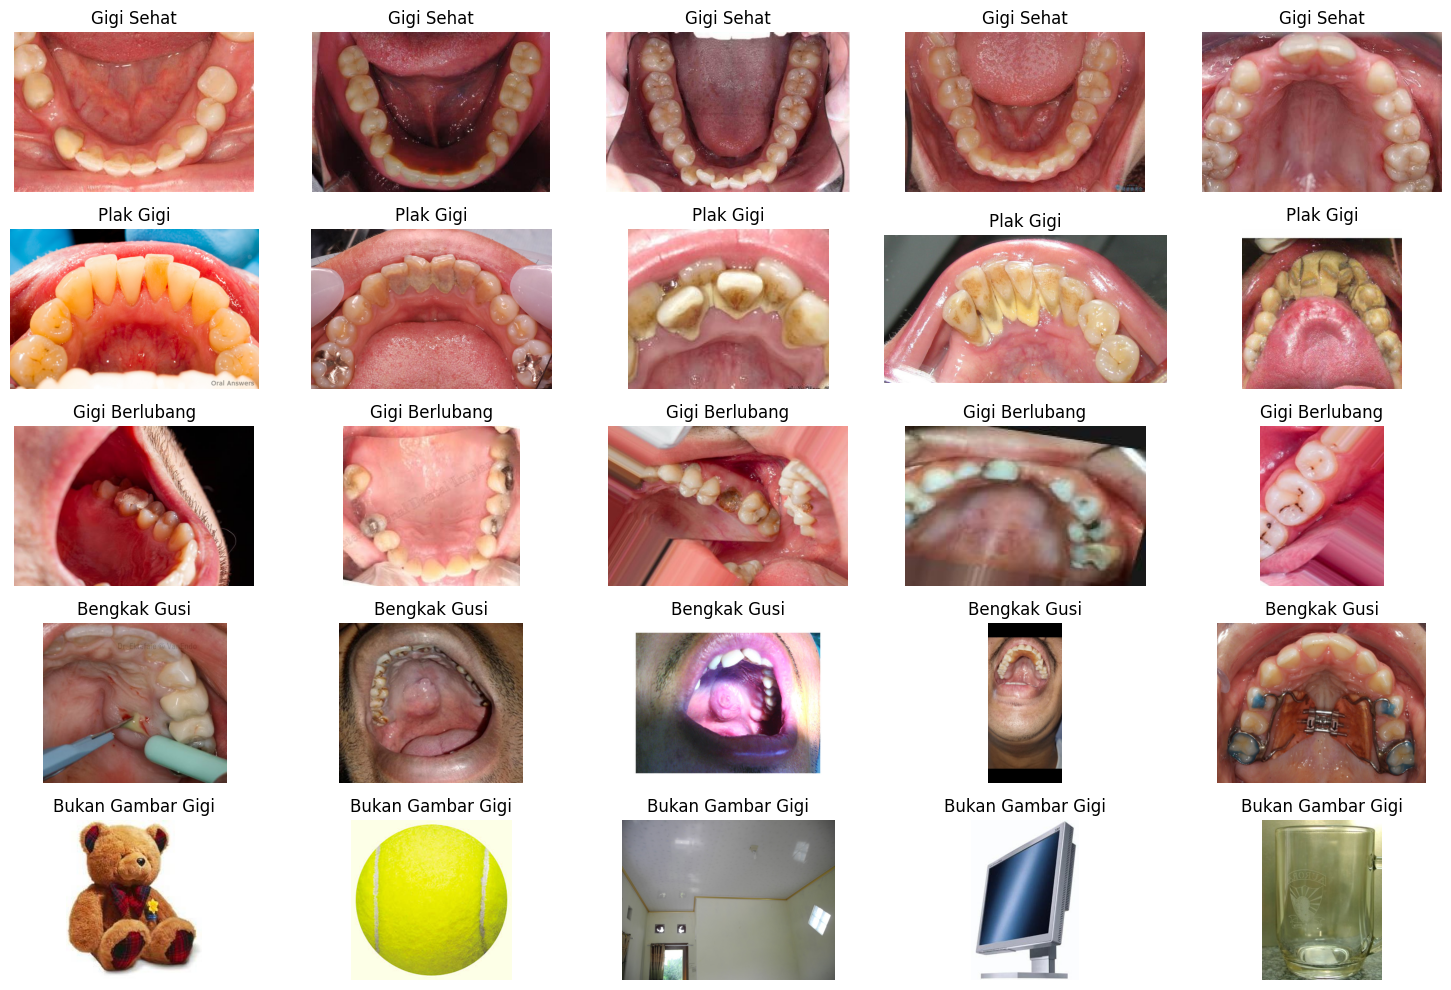

In [5]:
# Function to display sample images with labels
def display_sample_images(dataset_dir, num_samples=5):
    fig, axes = plt.subplots(len(folder_paths), num_samples, figsize=(15, 10))
    for i, (label, folder_path) in enumerate(folder_paths.items()):
        image_files = os.listdir(os.path.join(dataset_dir, label))
        sampled_images = image_files[:num_samples]
        for j, image_file in enumerate(sampled_images):
            image_path = os.path.join(dataset_dir, label, image_file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(image)
            axes[i, j].set_title(label)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images with labels
display_sample_images(dataset_dir)

In [6]:
import cv2

# Function to resize images
def resize_images(dataset_dir, target_size=(224, 224)):
    for label in os.listdir(dataset_dir):
        label_dir = os.path.join(dataset_dir, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = cv2.imread(image_path)
            resized_image = cv2.resize(image, target_size)
            cv2.imwrite(image_path, resized_image)

# Resize images in the dataset directory
resize_images(dataset_dir)

In [7]:
from sklearn.model_selection import train_test_split

# Function to split dataset into train and test sets
def split_dataset(dataset_dir, test_size=0.2):
    X = []
    y = []
    for i, (label, folder_path) in enumerate(folder_paths.items()):
        image_files = os.listdir(os.path.join(dataset_dir, label))
        for image_file in image_files:
            image_path = os.path.join(dataset_dir, label, image_file)
            X.append(image_path)
            y.append(i)  # Use index as label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = split_dataset(dataset_dir)

In [8]:
# Function to normalize images
def normalize_images(image_paths):
    X_normalized = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        normalized_image = image / 255.0  # Normalize pixel values to [0, 1]
        X_normalized.append(normalized_image)
    return np.array(X_normalized)

# Normalize train and test images
X_train_normalized = normalize_images(X_train)
X_test_normalized = normalize_images(X_test)

In [9]:
# Convert labels to one-hot encoding
num_classes = len(folder_paths)
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

In [10]:
# Define CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')  # num_classes should be defined based on your dataset
])

In [11]:
# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(X_train_normalized, y_train_categorical, epochs=30, batch_size=8,
                    validation_data=(X_test_normalized, y_test_categorical), callbacks=[checkpoint])

Epoch 1/30
253/253 [==============================] - ETA: 0s - loss: 1.5467 - accuracy: 0.6866
Epoch 1: val_accuracy improved from -inf to 0.32411, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


253/253 [==============================] - 25s 46ms/step - loss: 1.5467 - accuracy: 0.6866 - val_loss: 4.4387 - val_accuracy: 0.3241
Epoch 2/30
251/253 [============================>.] - ETA: 0s - loss: 0.7632 - accuracy: 0.8078
Epoch 2: val_accuracy improved from 0.32411 to 0.73123, saving model to best_model.h5
253/253 [==============================] - 8s 31ms/step - loss: 0.7634 - accuracy: 0.8082 - val_loss: 1.1806 - val_accuracy: 0.7312
Epoch 3/30
251/253 [============================>.] - ETA: 0s - loss: 0.4835 - accuracy: 0.8625
Epoch 3: val_accuracy improved from 0.73123 to 0.86759, saving model to best_model.h5
253/253 [==============================] - 8s 33ms/step - loss: 0.4824 - accuracy: 0.8621 - val_loss: 0.5508 - val_accuracy: 0.8676
Epoch 4/30
253/253 [==============================] - ETA: 0s - loss: 0.3616 - accuracy: 0.8898
Epoch 4: val_accuracy did not improve from 0.86759
253/253 [==============================] - 7s 28ms/step - loss: 0.3616 - accuracy: 0.8898 - 

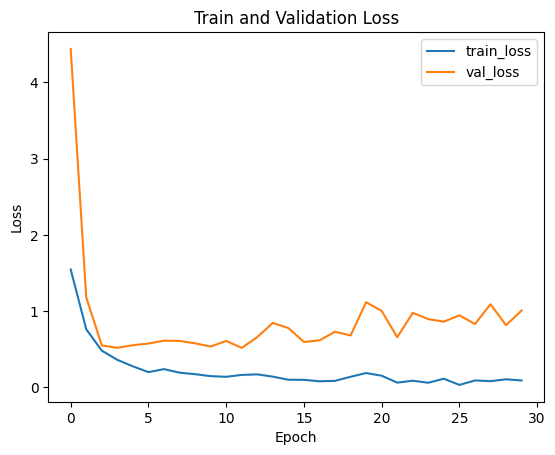

In [13]:
# Plot train and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

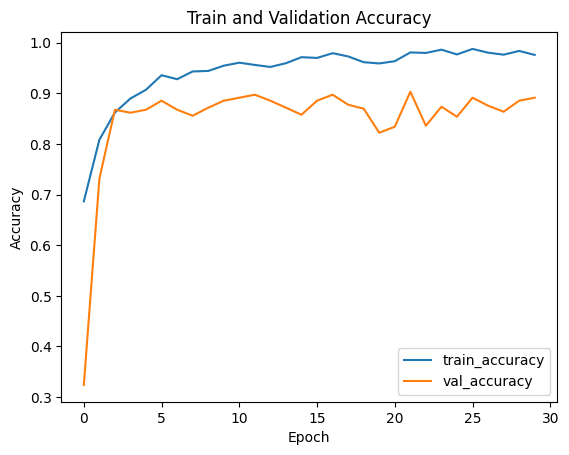

In [14]:
# Plot train and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()